In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import seaborn as sns

# %config InlineBackend.figure_format = 'retina'
# plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

In [2]:
#R code 5.1
d = pd.read_csv('Data/WaffleDivorce.csv', sep=';', header=0)
d['age_norm'] = (d.MedianAgeMarriage - d.MedianAgeMarriage.mean())/d.MedianAgeMarriage.std()
d['divorce_norm'] = (d.Divorce - d.Divorce.mean())/d.Divorce.std()

In [3]:
#R code 5.2
d.MedianAgeMarriage.std()

1.243630301388082

In [44]:
#R code 5.3 (out of order intentionally)
with pm.Model() as m_5_1:
    alpha = pm.Normal('alpha', mu=0, sd=0.2) 
    beta_age = pm.Normal('beta_age', mu=0, sd=0.5) 
    mu = pm.Deterministic('mu', alpha + beta_age*d.age_norm)
    sigma = pm.Exponential('sigma', 1)
    divorce = pm.Normal('height', mu=mu, sd=sigma, observed=d.divorce_norm)
    trace_5_1 = pm.sample(1000, tune=1000) 
    prior = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_age, alpha]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:03<00:00, 2410.28draws/s]


In [45]:
varnames = ['alpha','beta_age','sigma']
pm.summary(trace_5_1, varnames, alpha = 0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,-0.00,0.10,0.0,-0.16,0.16,7297.83,1.0
beta_age,-0.57,0.12,0.0,-0.76,-0.38,5506.28,1.0
sigma,0.82,0.09,0.0,0.69,0.96,4243.46,1.0


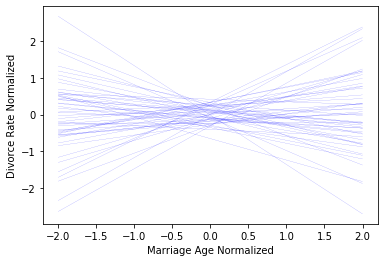

In [46]:
#R code 5.4. There are probably better ways to do this.
x = np.linspace(-2, 2, 100)
z=0
while z < 50:
    plt.plot(x, prior['alpha'][z] + prior['beta_age'][z]*x, linewidth=0.1, color='b')
    z+=1
plt.xlabel('Marriage Age Normalized')
plt.ylabel('Divorce Rate Normalized');

#The graph below shows that the priors we chose were bad. The standard deviation of the median age of marriage (not
#normalized) is 1.2 (R code 5.2). So, when the normalized marriage age is 1.0 (corresponding to an increase of age)
#of 1.2 years, our priors permit an increase in divorce rate by one full standard deviation.

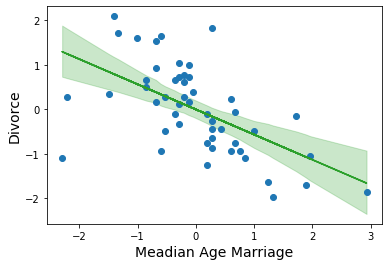

In [49]:
#R code 5.5, figure 5.2 (right)

mu_mean = trace_5_1['mu']
mu_hpd = pm.hpd(mu_mean)

plt.plot(d.age_norm, d.divorce_norm, 'C0o')
plt.plot(d.age_norm, mu_mean.mean(0), 'C2')

idx = np.argsort(d.age_norm)
plt.fill_between(d.age_norm[idx],
                 mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='C2', alpha=0.25)

plt.xlabel('Meadian Age Marriage', fontsize=14)
plt.ylabel('Divorce', fontsize=14);